# Climate Risk Analysis of Gobal Copper Price

# Introduction

# I. Copper Production

## I.A. Global Copper Production

## I.B. Copper Production in Chile

## I.C. Chile's Copper Import-Export 

# II. Climate risk impact on Chile

In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#### ENSO, or El Niño Southern Oscillation, is the variation of sea surface temperature accross the tropical Pacific ocean. When the trade wind weakens, the warm water to expand to the East, known as El Niño, resulting in warmer sea surface temperature in centeral pacific, flat thermocline, and central-pacific centered convection. Since Chile is on the East-South Pacific, and we know that precipitation affects copper industry, we wonder if ENSO (temperature and precipitation) plays a role in copper production. In other words, we wonder how does the temperature and precipitation variation cycle in Chile affect copper price and  production.

## II.A. ENSO

#### Load SST data from NASA

In [2]:
url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
ds_nino = xr.open_dataset(url, drop_variables=['time_bnds'])
ds_nino_sel = ds_nino.sel(time=slice('1900', '2020')).load()
ds_nino_sel

<xarray.Dataset> Size: 93MB
Dimensions:  (lat: 89, lon: 180, time: 1452)
Coordinates:
  * lat      (lat) float32 356B 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 720B 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 12kB 1900-01-01 1900-02-01 ... 2020-12-01
Data variables:
    sst      (time, lat, lon) float32 93MB -1.8 -1.8 -1.8 -1.8 ... nan nan nan
Attributes: (12/39)
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    ...                              ...
    comment:                         SSTs were observed by conventional therm...
    summary:                         ERSST.v5 is developed based on v4 after ...
    dataset_title:                   NOAA Extended Reconstructed SST V5
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    data_modified:                   2025-07-03
    DODS_EXTRA.Unlimited_Dimension:  time

#### Select lontitude latitude to Niño 3.4, and group time from 1951 to 1980 as a baseline (neutral). We see that temperature varies by +/- 2.8 during El Niño and La Niña year. We selected 1982 as our El Niño year and 1999 as La Niña year since they are more recent and both greatly affected Chile. 

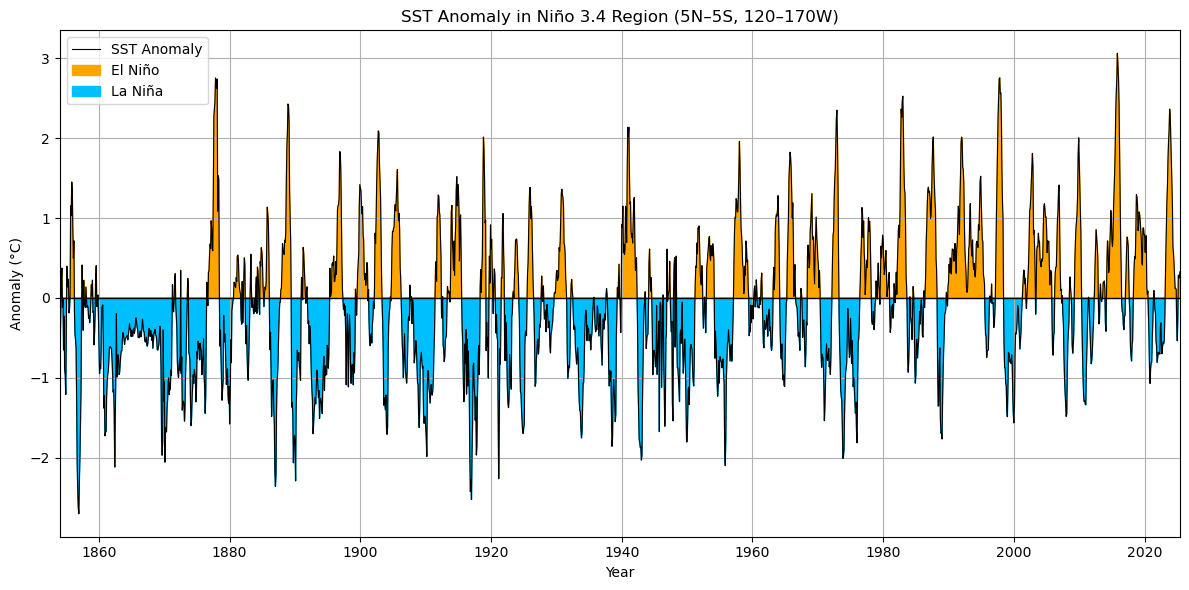

In [3]:
# Compute anomalies for niño 3.4 area
nino34 = ds_nino['sst'].sel(lat=slice(5, -5), lon=slice(190, 240))
nino34_mean = nino34.mean(dim=['lat', 'lon'], skipna=True)
clim = nino34_mean.sel(time=slice('1951', '1980')).groupby('time.month').mean('time')
anomalies = nino34_mean.groupby('time.month') - clim

# Plot
plt.figure(figsize=(12, 6))
plt.plot(anomalies['time'], anomalies, color='black', linewidth=0.8, label='SST Anomaly')

# Fill above and below normal
plt.fill_between(anomalies['time'], 0, anomalies, where=anomalies >= 0, color='orange', label='El Niño', interpolate=True)

plt.fill_between(anomalies['time'], 0, anomalies, where=anomalies < 0, color='deepskyblue', label='La Niña', interpolate=True)

# Styling
plt.axhline(0, color='black', linewidth=1)
plt.title('SST Anomaly in Niño 3.4 Region (5N–5S, 120–170W)')
plt.ylabel('Anomaly (°C)')
plt.xlabel('Year')
plt.grid(True)

# Remove whitespace on x axis
plt.xlim(anomalies['time'].values[0], anomalies['time'].values[-1])

plt.legend()
plt.tight_layout()
plt.show()

### 1982 El Niño vs. 1999 La Niña

#### We chose 1951-1980 as baseline for the global sst mean and computed the difference with 1982 and 1999. We see how during El Niño year the SST temperature is positive near Chile coast and vice versa for the La Niña year. Given that sst varies near Chile, this is why we decided to further look into the temperature and precipitation variation in Chile itself. 

In [6]:
# Compute monthly climatology from 1951–1980 (baseline)
clim = ds_nino['sst'].sel(time=slice('1951', '1980')).groupby('time.month').mean('time')

# Select data for 1982 and 1999
sst_1982 = ds_nino['sst'].sel(time=slice('1982-01-01', '1982-12-31'))
sst_1999 = ds_nino['sst'].sel(time=slice('1999-01-01', '1999-12-31'))

# Compute monthly anomalies
anom_1982 = sst_1982.groupby('time.month') - clim
anom_1999 = sst_1999.groupby('time.month') - clim

# Compute annual mean anomalies
anom_1982_annual = anom_1982.mean(dim='time')
anom_1999_annual = anom_1999.mean(dim='time')

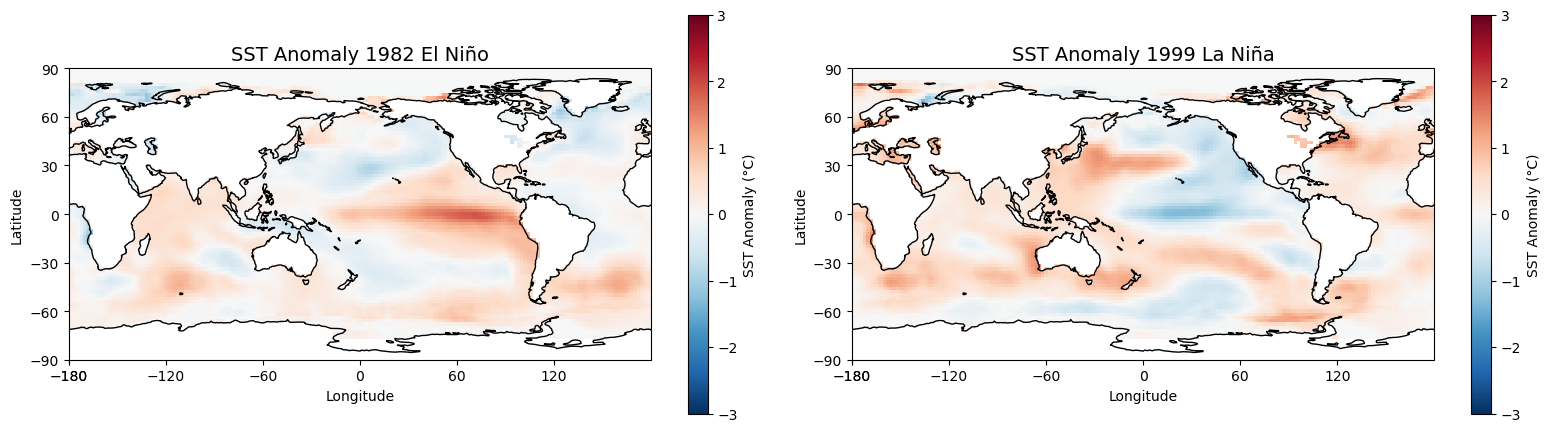

In [8]:
# 2 plots for el nino and la nina
fig, axes = plt.subplots(1, 2, figsize=(16, 6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Define common plot settings
vmin, vmax = -3, 3
cmap = 'RdBu_r'
xticks = range(0, 361, 60)
yticks = range(-90, 91, 30)

# Plot el niño 1982
plot1 = anom_1982_annual.plot(
    ax=axes[0],
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
    cbar_kwargs={'label': 'SST Anomaly (°C)', 'shrink': 0.7}
)
axes[0].set_title("SST Anomaly 1982 El Niño", fontsize=14)
axes[0].coastlines()
axes[0].set_xticks(xticks, crs=ccrs.PlateCarree())
axes[0].set_yticks(yticks, crs=ccrs.PlateCarree())
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")

# Plot la niña 1999
plot2 = anom_1999_annual.plot(
    ax=axes[1],
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
    cbar_kwargs={'label': 'SST Anomaly (°C)', 'shrink': 0.7}
)
axes[1].set_title("SST Anomaly 1999 La Niña", fontsize=14)
axes[1].coastlines()
axes[1].set_xticks(xticks, crs=ccrs.PlateCarree())
axes[1].set_yticks(yticks, crs=ccrs.PlateCarree())
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")

# Layout
plt.tight_layout()
plt.show()

## II.B. Temperature Variation

#### Now looking specifically at Chile's temperature variation, we used CESM2 model from CMIP6 and computed the difference between 1982 and 1999. The positive difference means that the temperature is higher in 1982 than 1999, and the negative difference means that the temperature is lower in 1982 than 1999. Overall, we see that there is a +/- 1.5C difference between those two years. We see that Mid to Northern Chile is warmer during El Niño year, and the Southern Chile is warmer during La Niña year. This shows how ENSO has an inverse effect on temperature in Chile on a latitude scale.

In [9]:
from xmip.preprocessing import combined_preprocessing
from xmip.utils import google_cmip_col
from xmip.postprocessing import match_metrics
import matplotlib.pyplot as plt

In [10]:
col = google_cmip_col()
col

Future exception was never retrieved
future: <Future finished exception=ClientConnectionError('Connection lost: [SSL: APPLICATION_DATA_AFTER_CLOSE_NOTIFY] application data after close notify (_ssl.c:2706)')>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.12/asyncio/sslproto.py", line 651, in _do_shutdown
    self._sslobj.unwrap()
  File "/srv/conda/envs/notebook/lib/python3.12/ssl.py", line 920, in unwrap
    return self._sslobj.shutdown()
           ^^^^^^^^^^^^^^^^^^^^^^^
ssl.SSLError: [SSL: APPLICATION_DATA_AFTER_CLOSE_NOTIFY] application data after close notify (_ssl.c:2706)

The above exception was the direct cause of the following exception:

aiohttp.client_exceptions.ClientConnectionError: Connection lost: [SSL: APPLICATION_DATA_AFTER_CLOSE_NOTIFY] application data after close notify (_ssl.c:2706)


,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


In [11]:
# load temperature data
cat_tas = col.search(
    source_id='CESM2',
    variable_id='tas',          # tas = near-surface air temperature
    table_id='Amon',
    experiment_id='historical',
    member_id='r1i1p1f1',
)

In [12]:
# Load temp dataset
ds_dict_tas = cat_tas.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': True})
ds_tas = list(ds_dict_tas.values())[0]
ds_tas


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


<xarray.Dataset> Size: 438MB
Dimensions:         (lat: 192, nbnd: 2, lon: 288, member_id: 1,
                     dcpp_init_year: 1, time: 1980)
Coordinates:
  * lat             (lat) float64 2kB -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
    lat_bnds        (lat, nbnd) float32 2kB dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon             (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
    lon_bnds        (lon, nbnd) float32 2kB dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time            (time) object 16kB 1850-01-15 12:00:00 ... 2014-12-15 12:...
    time_bnds       (time, nbnd) object 32kB dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * member_id       (member_id) object 8B 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
Dimensions without coordinates: nbnd
Data variables:
    tas             (member_id, dcpp_init_year, time, lat, lon) float32 438MB dask.array<chunksize=(1, 1, 600, 192, 288), meta=np.ndarray>
Attributes: (12/59)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             674885.0
    branch_time_in_parent:            219000.0
    case_id:                          15
    ...                               ...
    intake_esm_attrs:variable_id:     tas
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/NCAR/CESM2/histor...
    intake_esm_attrs:version:         20190308
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NCAR.CESM2.historical.Amon.gn

In [13]:
# Long Lat for Chile
lat_chile = slice(-56, -17)                      # 5S to 5N
lon_chile = slice(284, 294)                      # 66W to 76W (0–360)

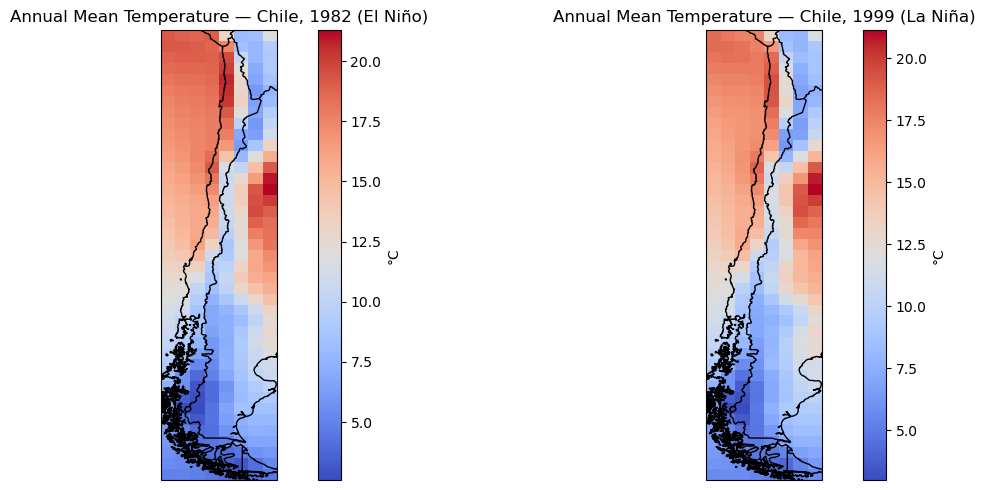

In [14]:
# Select annual temperature data
ds_tas_1982 = ds_tas['tas'].sel(time=slice('1982-01-01', '1982-12-31'), lat=lat_chile, lon=lon_chile)
ds_tas_1999 = ds_tas['tas'].sel(time=slice('1999-01-01', '1999-12-31'), lat=lat_chile, lon=lon_chile)

# Convert to Celsius and average over year
tas_1982 = ds_tas_1982.isel(member_id=0, dcpp_init_year=0) - 273.15
tas_1999 = ds_tas_1999.isel(member_id=0, dcpp_init_year=0) - 273.15

tas_1982_mean = tas_1982.mean(dim='time')
tas_1999_mean = tas_1999.mean(dim='time')

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# 1982
tas_1982_mean.plot(ax=axes[0], transform=ccrs.PlateCarree(), cmap='coolwarm',
                   cbar_kwargs={'label': '°C'})
axes[0].set_title('Annual Mean Temperature — Chile, 1982 (El Niño)')
axes[0].coastlines()
axes[0].add_feature(cfeature.BORDERS, linewidth=1)

# 1999
tas_1999_mean.plot(ax=axes[1], transform=ccrs.PlateCarree(), cmap='coolwarm',
                   cbar_kwargs={'label': '°C'})
axes[1].set_title('Annual Mean Temperature — Chile, 1999 (La Niña)')
axes[1].coastlines()
axes[1].add_feature(cfeature.BORDERS, linewidth=1)

plt.tight_layout()
plt.show()

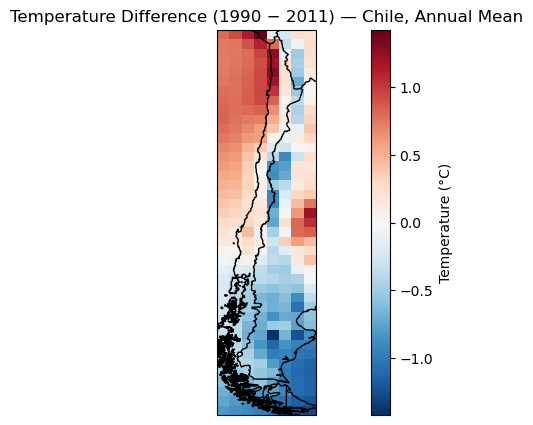

In [15]:
# Compute difference (°C)
tas_diff = tas_1982_mean - tas_1999_mean

# Plot difference
plt.figure(figsize=(14, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
tas_diff.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu_r', center=0,
              cbar_kwargs={'label': 'Temperature (°C)'})
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.set_title('Temperature Difference (1990 − 2011) — Chile, Annual Mean')
plt.show()

## II.C. Precipitation Variation

#### Now looking at Chile's precipitation variation using the same method, we again used CESM2 model from CMIP6 and computed the difference between sample years. The positive difference means that precipitation is higher in 1982; the negative difference means that precipitation is higher in 1999. We see that there's a +/- 35mm difference between those two years. During El Niño year, Central Chile has higher precipitation, and during La Niña year, Southern Chile has higher precipitation. Northern Chile does not experience much change in precipitation due to ENSO. 

In [16]:
# Load precipitation data
cat = col.search(
    source_id='CESM2',
    variable_id='pr',
    table_id='Amon',
    experiment_id='historical',
    member_id='r1i1p1f1',
)

In [17]:
# Load precip dataset
ds_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': True})
ds = list(ds_dict.values())[0]
ds


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


<xarray.Dataset> Size: 438MB
Dimensions:         (lat: 192, nbnd: 2, lon: 288, member_id: 1,
                     dcpp_init_year: 1, time: 1980)
Coordinates:
  * lat             (lat) float64 2kB -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
    lat_bnds        (lat, nbnd) float64 3kB dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon             (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
    lon_bnds        (lon, nbnd) float64 5kB dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time            (time) object 16kB 1850-01-15 12:00:00 ... 2014-12-15 12:...
    time_bnds       (time, nbnd) object 32kB dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * member_id       (member_id) object 8B 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
Dimensions without coordinates: nbnd
Data variables:
    pr              (member_id, dcpp_init_year, time, lat, lon) float32 438MB dask.array<chunksize=(1, 1, 600, 192, 288), meta=np.ndarray>
Attributes: (12/59)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             674885.0
    branch_time_in_parent:            219000.0
    case_id:                          15
    ...                               ...
    intake_esm_attrs:variable_id:     pr
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/NCAR/CESM2/histor...
    intake_esm_attrs:version:         20190401
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NCAR.CESM2.historical.Amon.gn

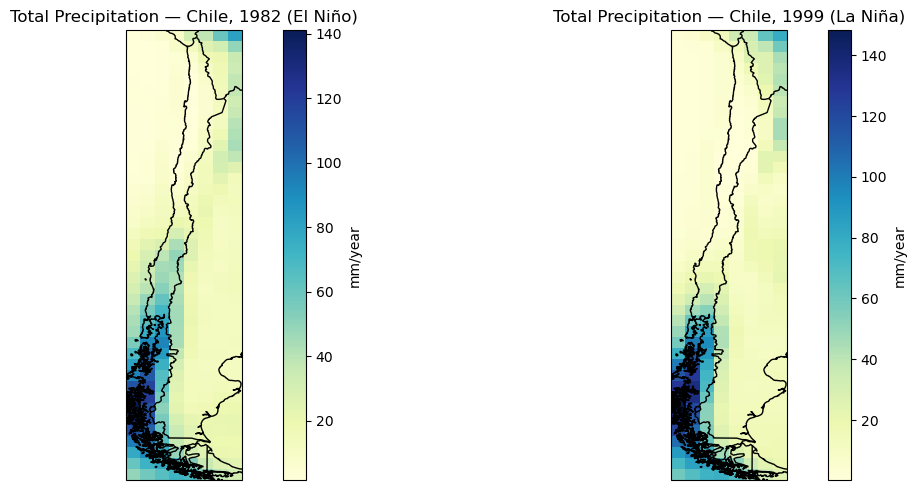

In [18]:
# Select year 1982 and 1999
ds_pr_1982 = ds['pr'].sel(time=slice('1982-01-01', '1982-12-31'), lat=lat_chile, lon=lon_chile)
ds_pr_1999 = ds['pr'].sel(time=slice('1999-01-01', '1999-12-31'), lat=lat_chile, lon=lon_chile)

# Convert to mm/year (from kg/m²/s = mm/s) (with help from google)
pr_1982_annual = ds_pr_1982.isel(member_id=0, dcpp_init_year=0) * 86400  # mm/day
pr_1999_annual = ds_pr_1999.isel(member_id=0, dcpp_init_year=0) * 86400

pr_1982_total = pr_1982_annual.sum(dim='time')
pr_1999_total = pr_1999_annual.sum(dim='time')

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# 1982 El Niño
pr_1982_total.plot(ax=axes[0], transform=ccrs.PlateCarree(), cmap='YlGnBu',
                   cbar_kwargs={'label': 'mm/year'})
axes[0].set_title('Total Precipitation — Chile, 1982 (El Niño)')
axes[0].coastlines()
axes[0].add_feature(cfeature.BORDERS, linewidth=1)

# 1999 La Niña
pr_1999_total.plot(ax=axes[1], transform=ccrs.PlateCarree(), cmap='YlGnBu',
                   cbar_kwargs={'label': 'mm/year'})
axes[1].set_title('Total Precipitation — Chile, 1999 (La Niña)')
axes[1].coastlines()
axes[1].add_feature(cfeature.BORDERS, linewidth=1)

plt.tight_layout()
plt.show()

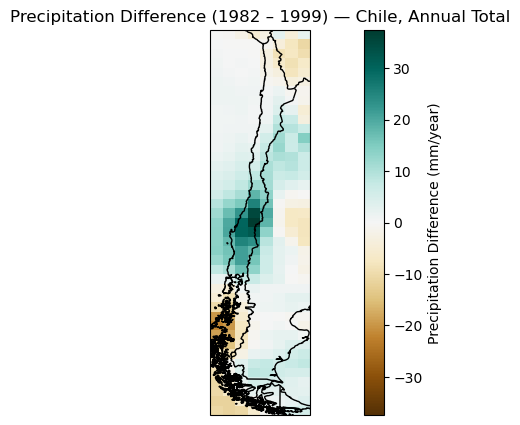

In [19]:
# Compute difference: El Niño − La Niña
pr_diff = pr_1982_total - pr_1999_total

# Plot difference map
plt.figure(figsize=(14, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
pr_diff.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='BrBG', center=0,
             cbar_kwargs={'label': 'Precipitation Difference (mm/year)'})
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.set_title('Precipitation Difference (1982 – 1999) — Chile, Annual Total')
plt.show()

# III. Regression Analysis
### Correlation between Cost, Climate and the Market

# IV. Future Scenario Projections on Copper Cost
### Cost Projection based on SSP 1,2,5 Scenarios